# Introduction

The majority of this notebook was retrived from Ashish Gupta's kernel: https://www.kaggle.com/roydatascience/elo-merchant-recommendation-fathers-day-specials



## Python libraries needed

* [Anaconda](https://anaconda.org)
* [XGBoost](https://github.com/dmlc/xgboost)
* [LightGBM](https://github.com/Microsoft/LightGBM) - not needed by week 1
* [Keras](https://keras.io) - not needed by week 1
* [Tensorflow](https://www.tensorflow.org) - not needed by week 1
* [Bayesian Optimization](https://github.com/fmfn/BayesianOptimization) - not needed by week 1
* [seaborn](https://seaborn.pydata.org)
* [bokeh](http://bokeh.pydata.org)


## Local directory
If you want to run it locally the following directory structure is recommended:

```
elo-merchant-category-recommendation
└───python
│   │   your.ipynb
│   │   ...
└───input
│   │   train.csv
│   │   test.csv
> │   │   ...
└───output
    │   submission.csv
    │   ...
    

In [1]:
## Data manipulation
import numpy as np
import pandas as pd

## Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
plt.style.use('seaborn')


## Modelling
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge,ElasticNet, SGDRegressor
from scipy import sparse
from scipy.stats import norm, skew


## Others
import os
import time
import datetime
import warnings
import gc
import os
import pickle
from six.moves import urllib
import warnings
warnings.filterwarnings('ignore')


# Data preprocessing

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_hist_trans = pd.read_csv('../input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv')

In [3]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [4]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [5]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

# Feature engineering
Given that we are working largely on transactional data so the key to feature engineering for this competitin is how to appropriately aggregate transactions to card level and essentially 

1. How can we aggregate numerical features?
2. How can we aggregate cateogrical features?
3. Do we need to use different statistical metrics for different features? Why? How can we find the appropriate metrics?
4. How to generate feature interactions?


## Aggregate history transations

In [6]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

28

## Aggregate new transactions

In [7]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

182

In [8]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

## Create hist-new interacations

In [9]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)


# Training the model

Here we will be using a technique called "stacking" to train the model. We will take a dive into stacking in week 3 and for now you can just think it as a normal training-predicting process.

In [10]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']

In [11]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.37467	valid_1's rmse: 3.65472
Early stopping, best iteration is:
[1318]	training's rmse: 3.32485	valid_1's rmse: 3.65375
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.37119	valid_1's rmse: 3.65632
Early stopping, best iteration is:
[1141]	training's rmse: 3.34757	valid_1's rmse: 3.65598
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.37235	valid_1's rmse: 3.65395
Early stopping, best iteration is:
[1462]	training's rmse: 3.30241	valid_1's rmse: 3.65148
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.37295	valid_1's rmse: 3.6575
Early stopping, best iteration is:
[1393]	training's rmse: 3.31071	valid_1's rmse: 3.65585
fold 4
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.36796	valid_1's rmse: 3.6516
Early st

3.653599140260281

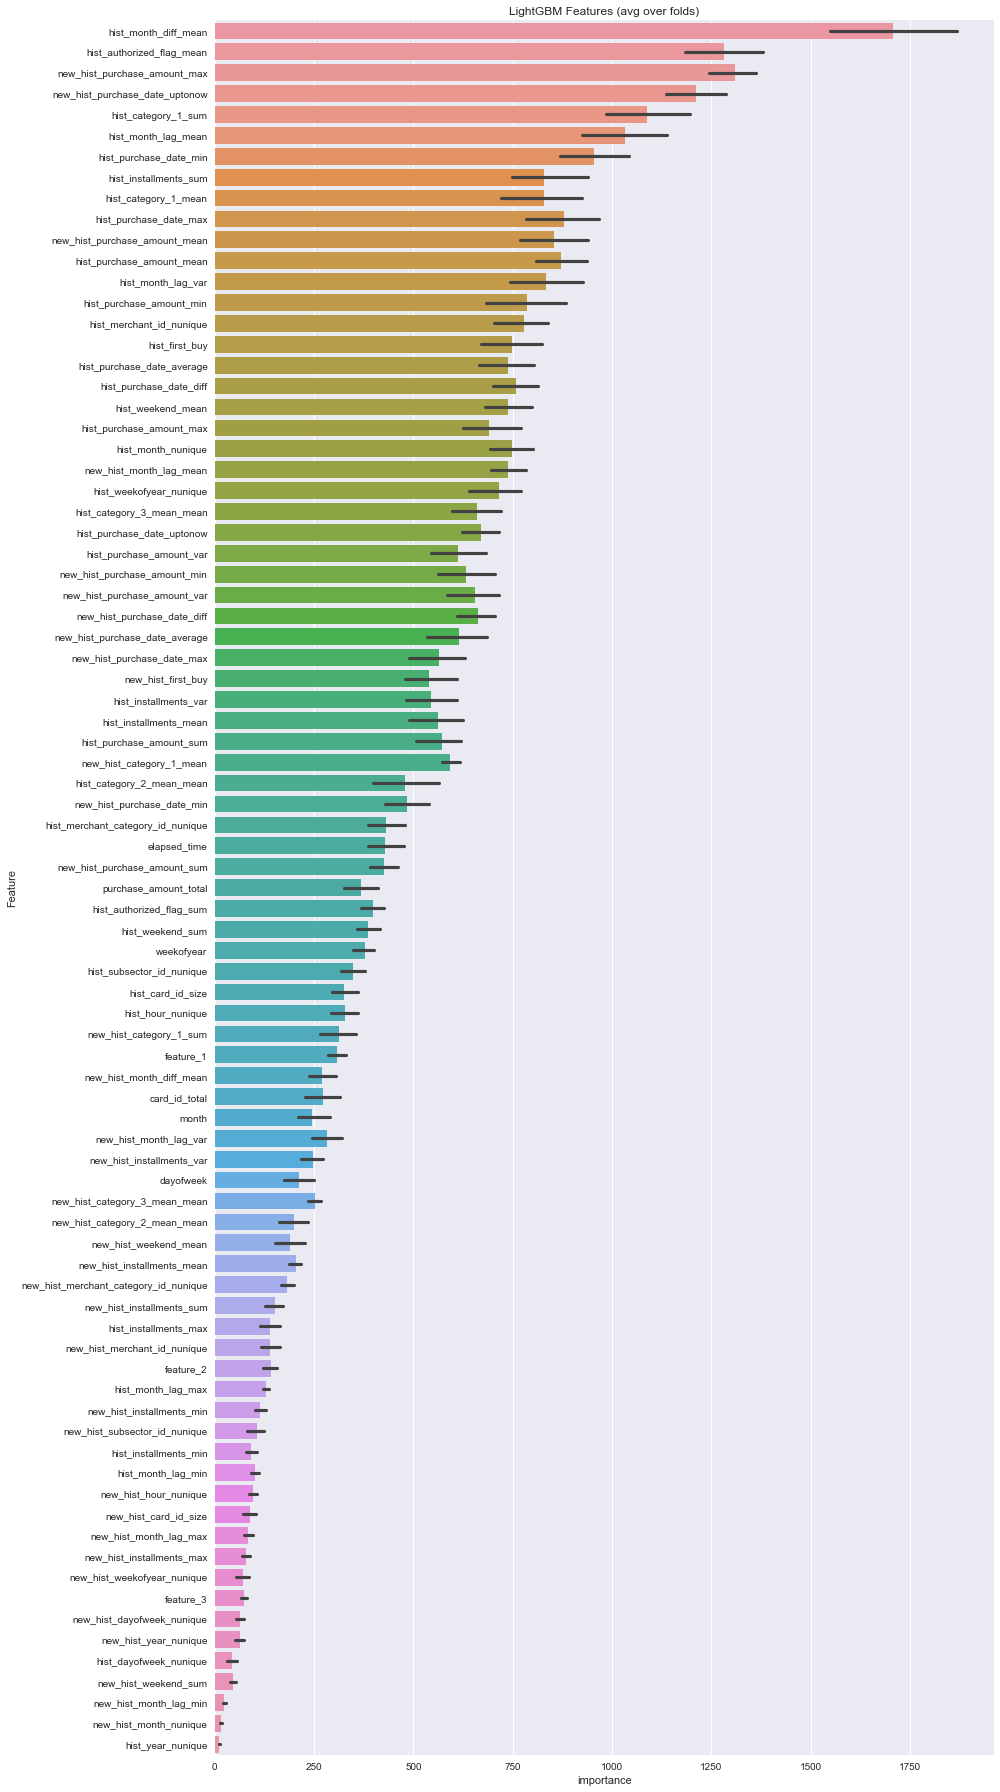

In [12]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [13]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_starter.csv", index=False)

# Additional feature engineerings

### Generating finer aggregations using pandas pivot table

In [14]:
df_hist_pivot = df_hist_trans.pivot_table(index='card_id', columns='month_lag', values='merchant_id', aggfunc='count')
df_hist_pivot.columns = ['hist_tran_count_month_lag_' + str(c) for c in df_hist_pivot.columns]
hist_month_lag_count_columns = list(df_hist_pivot.columns)
df_hist_pivot = df_hist_pivot.reset_index()
df_hist_pivot.head()

,card_id,hist_tran_count_month_lag_-13,hist_tran_count_month_lag_-12,hist_tran_count_month_lag_-11,hist_tran_count_month_lag_-10,hist_tran_count_month_lag_-9,hist_tran_count_month_lag_-8,hist_tran_count_month_lag_-7,hist_tran_count_month_lag_-6,hist_tran_count_month_lag_-5,hist_tran_count_month_lag_-4,hist_tran_count_month_lag_-3,hist_tran_count_month_lag_-2,hist_tran_count_month_lag_-1,hist_tran_count_month_lag_0
0,C_ID_00007093c1,NaN,4.0,10.0,12.0,10.0,19.0,15.0,17.0,5.0,17.0,6.0,12.0,10.0,12.0
1,C_ID_0001238066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,11.0,23.0,37.0,26.0,24.0
2,C_ID_0001506ef0,2.0,5.0,8.0,NaN,1.0,3.0,2.0,2.0,2.0,3.0,7.0,18.0,7.0,6.0
3,C_ID_0001793786,NaN,NaN,NaN,NaN,2.0,6.0,16.0,30.0,4.0,37.0,29.0,34.0,38.0,20.0
4,C_ID_000183fdda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,22.0,25.0,9.0,26.0,28.0,28.0


In [15]:
df_train = df_train.merge(df_hist_pivot,on='card_id',how='left')
df_test = df_test.merge(df_hist_pivot,on='card_id',how='left')
print (df_train.shape, df_test.shape)

(201917, 101) (123623, 99)


In [16]:
del df_hist_pivot
gc.collect()

17288

Let's rerun the model with newly added features:

In [17]:
df_train_columns = ['feature_1',
                    'feature_2',
                    'feature_3',
                    'hist_month_nunique',
                    'hist_hour_nunique',
                    'hist_weekofyear_nunique',
                    'hist_dayofweek_nunique',
                    'hist_year_nunique',
                    'hist_subsector_id_nunique',
                    'hist_merchant_id_nunique',
                    'hist_merchant_category_id_nunique',
                    'hist_purchase_amount_sum',
                    'hist_purchase_amount_max',
                    'hist_purchase_amount_min',
                    'hist_purchase_amount_mean',
                    'hist_purchase_amount_var',
                    'hist_installments_sum',
                    'hist_installments_max',
                    'hist_installments_min',
                    'hist_installments_mean',
                    'hist_installments_var',
                    'hist_purchase_date_max',
                    'hist_purchase_date_min',
                    'hist_month_lag_max',
                    'hist_month_lag_min',
                    'hist_month_lag_mean',
                    'hist_month_lag_var',
                    'hist_month_diff_mean',
                    'hist_authorized_flag_sum',
                    'hist_authorized_flag_mean',
                    'hist_weekend_sum',
                    'hist_weekend_mean',
                    'hist_category_1_sum',
                    'hist_category_1_mean',
                    'hist_card_id_size',
                    'hist_category_2_mean_mean',
                    'hist_category_3_mean_mean',
                    'hist_purchase_date_diff',
                    'hist_purchase_date_average',
                    'hist_purchase_date_uptonow',
                    'new_hist_month_nunique',
                    'new_hist_hour_nunique',
                    'new_hist_weekofyear_nunique',
                    'new_hist_dayofweek_nunique',
                    'new_hist_year_nunique',
                    'new_hist_subsector_id_nunique',
                    'new_hist_merchant_id_nunique',
                    'new_hist_merchant_category_id_nunique',
                    'new_hist_purchase_amount_sum',
                    'new_hist_purchase_amount_max',
                    'new_hist_purchase_amount_min',
                    'new_hist_purchase_amount_mean',
                    'new_hist_purchase_amount_var',
                    'new_hist_installments_sum',
                    'new_hist_installments_max',
                    'new_hist_installments_min',
                    'new_hist_installments_mean',
                    'new_hist_installments_var',
                    'new_hist_purchase_date_max',
                    'new_hist_purchase_date_min',
                    'new_hist_month_lag_max',
                    'new_hist_month_lag_min',
                    'new_hist_month_lag_mean',
                    'new_hist_month_lag_var',
                    'new_hist_month_diff_mean',
                    'new_hist_weekend_sum',
                    'new_hist_weekend_mean',
                    'new_hist_category_1_sum',
                    'new_hist_category_1_mean',
                    'new_hist_card_id_size',
                    'new_hist_category_2_mean_mean',
                    'new_hist_category_3_mean_mean',
                    'new_hist_purchase_date_diff',
                    'new_hist_purchase_date_average',
                    'new_hist_purchase_date_uptonow',
                    'dayofweek',
                    'weekofyear',
                    'month',
                    'elapsed_time',
                    'hist_first_buy',
                    'new_hist_first_buy',
                    'card_id_total',
                    'purchase_amount_total'] + hist_month_lag_count_columns

In [18]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.35559	valid_1's rmse: 3.65601
Early stopping, best iteration is:
[1348]	training's rmse: 3.29667	valid_1's rmse: 3.65508
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.35105	valid_1's rmse: 3.65186
Early stopping, best iteration is:
[1496]	training's rmse: 3.26561	valid_1's rmse: 3.64949
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.3551	valid_1's rmse: 3.65142
Early stopping, best iteration is:
[1614]	training's rmse: 3.25757	valid_1's rmse: 3.64929
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.35436	valid_1's rmse: 3.65401
Early stopping, best iteration is:
[1680]	training's rmse: 3.24955	valid_1's rmse: 3.65037
fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[823]	training's rmse: 3.385

3.6519040339294375

In [19]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_1.csv", index=False)

## Aggregate categorical features in transactions with NLP embedding

In [20]:
df_hist_tran_as_sentence = df_hist_trans[['card_id','merchant_id']].astype('unicode').fillna('None')\
        .groupby('card_id')['merchant_id'].apply(list).apply(lambda x: ','.join(x)).reset_index()

In [21]:
encoder = CountVectorizer(tokenizer=lambda x: x.split(','))
topic_sparse = encoder.fit_transform(df_hist_tran_as_sentence['merchant_id'].values)
decomposer = TruncatedSVD(n_components=10)
topic_matrix = decomposer.fit_transform(topic_sparse)

df_hist_tfidf = pd.DataFrame(topic_matrix, columns=['tfidf_' + 'merchant_id' + '_' + str(i) for i in range(10)])
tfidf_hist_merchant_columns = list(df_hist_tfidf.columns)
df_hist_tfidf['card_id'] = df_hist_tran_as_sentence['card_id']

In [22]:
df_train = df_train.merge(df_hist_tfidf,on='card_id',how='left')
df_test = df_test.merge(df_hist_tfidf,on='card_id',how='left')
print (df_train.shape, df_test.shape)

del df_hist_tfidf
gc.collect(0)

(201917, 111) (123623, 109)


42

In [23]:
df_train_columns = ['feature_1',
                    'feature_2',
                    'feature_3',
                    'hist_month_nunique',
                    'hist_hour_nunique',
                    'hist_weekofyear_nunique',
                    'hist_dayofweek_nunique',
                    'hist_year_nunique',
                    'hist_subsector_id_nunique',
                    'hist_merchant_id_nunique',
                    'hist_merchant_category_id_nunique',
                    'hist_purchase_amount_sum',
                    'hist_purchase_amount_max',
                    'hist_purchase_amount_min',
                    'hist_purchase_amount_mean',
                    'hist_purchase_amount_var',
                    'hist_installments_sum',
                    'hist_installments_max',
                    'hist_installments_min',
                    'hist_installments_mean',
                    'hist_installments_var',
                    'hist_purchase_date_max',
                    'hist_purchase_date_min',
                    'hist_month_lag_max',
                    'hist_month_lag_min',
                    'hist_month_lag_mean',
                    'hist_month_lag_var',
                    'hist_month_diff_mean',
                    'hist_authorized_flag_sum',
                    'hist_authorized_flag_mean',
                    'hist_weekend_sum',
                    'hist_weekend_mean',
                    'hist_category_1_sum',
                    'hist_category_1_mean',
                    'hist_card_id_size',
                    'hist_category_2_mean_mean',
                    'hist_category_3_mean_mean',
                    'hist_purchase_date_diff',
                    'hist_purchase_date_average',
                    'hist_purchase_date_uptonow',
                    'new_hist_month_nunique',
                    'new_hist_hour_nunique',
                    'new_hist_weekofyear_nunique',
                    'new_hist_dayofweek_nunique',
                    'new_hist_year_nunique',
                    'new_hist_subsector_id_nunique',
                    'new_hist_merchant_id_nunique',
                    'new_hist_merchant_category_id_nunique',
                    'new_hist_purchase_amount_sum',
                    'new_hist_purchase_amount_max',
                    'new_hist_purchase_amount_min',
                    'new_hist_purchase_amount_mean',
                    'new_hist_purchase_amount_var',
                    'new_hist_installments_sum',
                    'new_hist_installments_max',
                    'new_hist_installments_min',
                    'new_hist_installments_mean',
                    'new_hist_installments_var',
                    'new_hist_purchase_date_max',
                    'new_hist_purchase_date_min',
                    'new_hist_month_lag_max',
                    'new_hist_month_lag_min',
                    'new_hist_month_lag_mean',
                    'new_hist_month_lag_var',
                    'new_hist_month_diff_mean',
                    'new_hist_weekend_sum',
                    'new_hist_weekend_mean',
                    'new_hist_category_1_sum',
                    'new_hist_category_1_mean',
                    'new_hist_card_id_size',
                    'new_hist_category_2_mean_mean',
                    'new_hist_category_3_mean_mean',
                    'new_hist_purchase_date_diff',
                    'new_hist_purchase_date_average',
                    'new_hist_purchase_date_uptonow',
                    'dayofweek',
                    'weekofyear',
                    'month',
                    'elapsed_time',
                    'hist_first_buy',
                    'new_hist_first_buy',
                    'card_id_total',
                    'purchase_amount_total'] + hist_month_lag_count_columns + tfidf_hist_merchant_columns

In [24]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34352	valid_1's rmse: 3.6536
Early stopping, best iteration is:
[1384]	training's rmse: 3.27645	valid_1's rmse: 3.65177
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.33938	valid_1's rmse: 3.65188
Early stopping, best iteration is:
[968]	training's rmse: 3.34584	valid_1's rmse: 3.6516
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34148	valid_1's rmse: 3.64647
Early stopping, best iteration is:
[1757]	training's rmse: 3.21869	valid_1's rmse: 3.64321
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34193	valid_1's rmse: 3.6539
Early stopping, best iteration is:
[1572]	training's rmse: 3.24688	valid_1's rmse: 3.65008
fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[881]	training's rmse: 3.35975	

3.6496305891595258

In [25]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_2.csv", index=False)

## Food for thoughts

There are a few thoughts that might be the key to success for this competition:

1. Outliers
    *     The majority of RMSE was contributed by outliers. How can we handle or leverage it? What
    *      What could the outliers actually be?
2.  Month lag
    *     What does "month lag" mean? 
    *     Why it appears to be important?
    *     How can we leverage it?
3.  Installments
    *     What does "installments" mean? 
    *     How can we leverage it?
    *     What does installment interact with other features such as month lag, cateogrical 3 etc?
4. Purchase amount
    *     Why purchase amount can be negative?
    *     Why there are a lot of positive outliers on purchase amount?
    *     Why it's not as important as expected?
5.   New vs history transactions
    *   Why there's no overlap between history and new transactions? 
    *   What could be the relationship between history and new transactions?
   
   

## Overdue

In [251]:
# df_train.drop('sum_installment_to_month_lag', inplace=True, axis=1)
# df_test.drop('sum_installment_to_month_lag', inplace=True, axis=1)

# df_train.drop('count_installment_to_month_lag', inplace=True, axis=1)
# df_test.drop('count_installment_to_month_lag', inplace=True, axis=1)
gc.collect()
# df_hist_trans.drop('max_month_lag', inplace=True, axis=1)

# df_hist_group = pd.concat([df_new_merchant_trans[['card_id','month_lag']], df_hist_trans[['card_id','month_lag']]]).groupby('card_id').month_lag.max().reset_index()
# df_hist_group = df_hist_trans.groupby('card_id').month_lag.max().reset_index()
# df_hist_group.columns=['card_id', 'max_month_lag']

# df_hist_trans = df_hist_trans.merge(df_hist_group,on='card_id',how='left')

# df_hist_trans['month_diff'] = df_hist_trans['max_month_lag'] - df_hist_trans['month_lag']
# df_hist_trans['overdue_month'] = df_hist_trans['installments'] - df_hist_trans['month_diff']

# df_hist_trans['installment_to_month_lag'] = df_hist_trans['installments'] + df_hist_trans['month_lag'] - 2
# df_hist_group = df_hist_trans.query('installment_to_month_lag>0').\
#     groupby('card_id')['installment_to_month_lag'].agg(['sum', 'count']).reset_index()
# df_hist_group = df_hist_trans.groupby('card_id')['installment_to_month_lag'].sum().reset_index()


# df_hist_group.columns=['card_id', 'sum_installment_to_month_lag', 'count_installment_to_month_lag']

# df_train = df_train.merge(df_hist_group,on='card_id',how='left')
# df_test = df_test.merge(df_hist_group,on='card_id',how='left')


# df_train.drop('due_purchase_amount', inplace=True, axis=1)
# df_test.drop('due_purchase_amount', inplace=True, axis=1)


# df_hist_trans['due_purchase_amount'] = 0
# df_hist_trans.loc[df_hist_trans['installment_to_month_lag']>0, 'due_purchase_amount'] = \
#         df_hist_trans.loc[df_hist_trans['installment_to_month_lag']>0, 'purchase_amount'] / \
#         df_hist_trans.loc[df_hist_trans['installment_to_month_lag']>0, 'installment_to_month_lag']

# df_hist_group = df_hist_trans.query('installment_to_month_lag>0').\
#     groupby('card_id')['due_purchase_amount'].sum().reset_index()


# df_hist_group.columns=['card_id', 'due_purchase_amount']

# df_train = df_train.merge(df_hist_group,on='card_id',how='left')
# df_test = df_test.merge(df_hist_group,on='card_id',how='left')


df_train.drop('sum_overdue_month', inplace=True, axis=1)
df_test.drop('sum_overdue_month', inplace=True, axis=1)



df_train.drop('count_overdue', inplace=True, axis=1)
df_test.drop('count_overdue', inplace=True, axis=1)

df_hist_group = df_hist_trans.query('overdue_month>0 & max_month_lag<0').groupby('card_id')['overdue_month'].agg(['sum','count']).reset_index()
df_hist_group.columns=['card_id', 'sum_overdue_month', 'count_overdue']

# df_hist_trans['due_purchase_amount'] = 0
# df_hist_trans.loc[df_hist_trans['installment_to_month_lag']>0, 'due_purchase_amount'] = \
#         df_hist_trans.loc[df_hist_trans['installment_to_month_lag']>0, 'purchase_amount'] / \
#         df_hist_trans.loc[df_hist_trans['installment_to_month_lag']>0, 'installment_to_month_lag']

df_train = df_train.merge(df_hist_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_group,on='card_id',how='left')


In [252]:
df_hist_trans.query('overdue_month>1 & max_month_lag<0').head(10)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,dayofweek,weekend,hour,month_diff,category_2_mean,category_3_mean,installment_to_month_lag,due_purchase_amount,overdue_month,max_month_lag
6392,1,C_ID_0d6b8c2d0f,19,0,3,C,422,M_ID_89e9e5c469,-2,-0.476731,...,2,0,18,0,0.074568,0.106023,-1,0.000000,3,-2
7076,1,C_ID_190bd090c9,286,0,2,C,690,M_ID_b98b4f4f5c,-1,-0.589685,...,4,0,17,0,0.180375,0.106023,-1,0.000000,2,-1
11902,1,C_ID_90eb72061a,69,0,3,C,178,M_ID_02a0741b01,-2,-0.255045,...,1,0,16,1,0.074568,0.106023,-1,0.000000,2,-1
11964,1,C_ID_90eb72061a,69,0,10,C,111,M_ID_fdaa62eccb,-4,4.510869,...,1,0,18,3,0.074568,0.106023,4,1.127717,7,-1
11993,1,C_ID_90eb72061a,69,0,3,C,367,M_ID_820c7b73c8,-2,-0.238651,...,2,0,21,1,0.074568,0.106023,-1,0.000000,2,-1
12023,1,C_ID_90eb72061a,69,0,10,C,210,M_ID_d3efd95cc7,-1,0.055643,...,4,0,12,0,0.074568,0.106023,7,0.007949,10,-1
19958,1,C_ID_9861d0fa05,17,0,6,C,734,M_ID_e4ca6a905c,-5,1.197523,...,0,0,22,1,-0.158951,0.106023,-1,0.000000,5,-4
19969,1,C_ID_9861d0fa05,-1,1,6,C,879,M_ID_9139332ccc,-6,-0.587942,...,5,1,20,2,0.074568,0.106023,-2,0.000000,4,-4
19981,1,C_ID_9861d0fa05,-1,1,10,C,879,M_ID_9139332ccc,-6,-0.153361,...,6,1,0,2,0.074568,0.106023,2,-0.076680,8,-4
19990,1,C_ID_9861d0fa05,17,0,6,C,412,M_ID_544d4943d9,-6,3.534145,...,4,0,9,2,-0.158951,0.106023,-2,0.000000,4,-4


In [253]:
df_train_columns = ['feature_1',
                    'feature_2',
                    'feature_3',
                    'hist_month_nunique',
                    'hist_hour_nunique',
                    'hist_weekofyear_nunique',
                    'hist_dayofweek_nunique',
                    'hist_year_nunique',
                    'hist_subsector_id_nunique',
                    'hist_merchant_id_nunique',
                    'hist_merchant_category_id_nunique',
                    'hist_purchase_amount_sum',
                    'hist_purchase_amount_max',
                    'hist_purchase_amount_min',
                    'hist_purchase_amount_mean',
                    'hist_purchase_amount_var',
                    'hist_installments_sum',
                    'hist_installments_max',
                    'hist_installments_min',
                    'hist_installments_mean',
                    'hist_installments_var',
                    'hist_purchase_date_max',
                    'hist_purchase_date_min',
                    'hist_month_lag_max',
                    'hist_month_lag_min',
                    'hist_month_lag_mean',
                    'hist_month_lag_var',
                    'hist_month_diff_mean',
                    'hist_authorized_flag_sum',
                    'hist_authorized_flag_mean',
                    'hist_weekend_sum',
                    'hist_weekend_mean',
                    'hist_category_1_sum',
                    'hist_category_1_mean',
                    'hist_card_id_size',
                    'hist_category_2_mean_mean',
                    'hist_category_3_mean_mean',
                    'hist_purchase_date_diff',
                    'hist_purchase_date_average',
                    'hist_purchase_date_uptonow',
                    'new_hist_month_nunique',
                    'new_hist_hour_nunique',
                    'new_hist_weekofyear_nunique',
                    'new_hist_dayofweek_nunique',
                    'new_hist_year_nunique',
                    'new_hist_subsector_id_nunique',
                    'new_hist_merchant_id_nunique',
                    'new_hist_merchant_category_id_nunique',
                    'new_hist_purchase_amount_sum',
                    'new_hist_purchase_amount_max',
                    'new_hist_purchase_amount_min',
                    'new_hist_purchase_amount_mean',
                    'new_hist_purchase_amount_var',
                    'new_hist_installments_sum',
                    'new_hist_installments_max',
                    'new_hist_installments_min',
                    'new_hist_installments_mean',
                    'new_hist_installments_var',
                    'new_hist_purchase_date_max',
                    'new_hist_purchase_date_min',
                    'new_hist_month_lag_max',
                    'new_hist_month_lag_min',
                    'new_hist_month_lag_mean',
                    'new_hist_month_lag_var',
                    'new_hist_month_diff_mean',
                    'new_hist_weekend_sum',
                    'new_hist_weekend_mean',
                    'new_hist_category_1_sum',
                    'new_hist_category_1_mean',
                    'new_hist_card_id_size',
                    'new_hist_category_2_mean_mean',
                    'new_hist_category_3_mean_mean',
                    'new_hist_purchase_date_diff',
                    'new_hist_purchase_date_average',
                    'new_hist_purchase_date_uptonow',
                    'dayofweek',
                    'weekofyear',
                    'month',
                    'elapsed_time',
                    'hist_first_buy',
                    'new_hist_first_buy',
                    'card_id_total',
                    'purchase_amount_total'] + hist_month_lag_count_columns + tfidf_hist_merchant_columns + \
[
    'count_overdue',
# 'sum_overdue_month'
]

In [254]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34207	valid_1's rmse: 3.65351
Early stopping, best iteration is:
[1183]	training's rmse: 3.30879	valid_1's rmse: 3.65249
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.33742	valid_1's rmse: 3.65163
Early stopping, best iteration is:
[1169]	training's rmse: 3.30623	valid_1's rmse: 3.65113
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34343	valid_1's rmse: 3.64304
Early stopping, best iteration is:
[1568]	training's rmse: 3.24903	valid_1's rmse: 3.64099
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34151	valid_1's rmse: 3.65351
[2000]	training's rmse: 3.18477	valid_1's rmse: 3.64832
Early stopping, best iteration is:
[2097]	training's rmse: 3.17104	valid_1's rmse: 3.64779
fold 4
Training until validation scores don't improve for 100 rounds.
[1000]

3.64872957602847

In [255]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_2_overdue_count_1.csv", index=False)

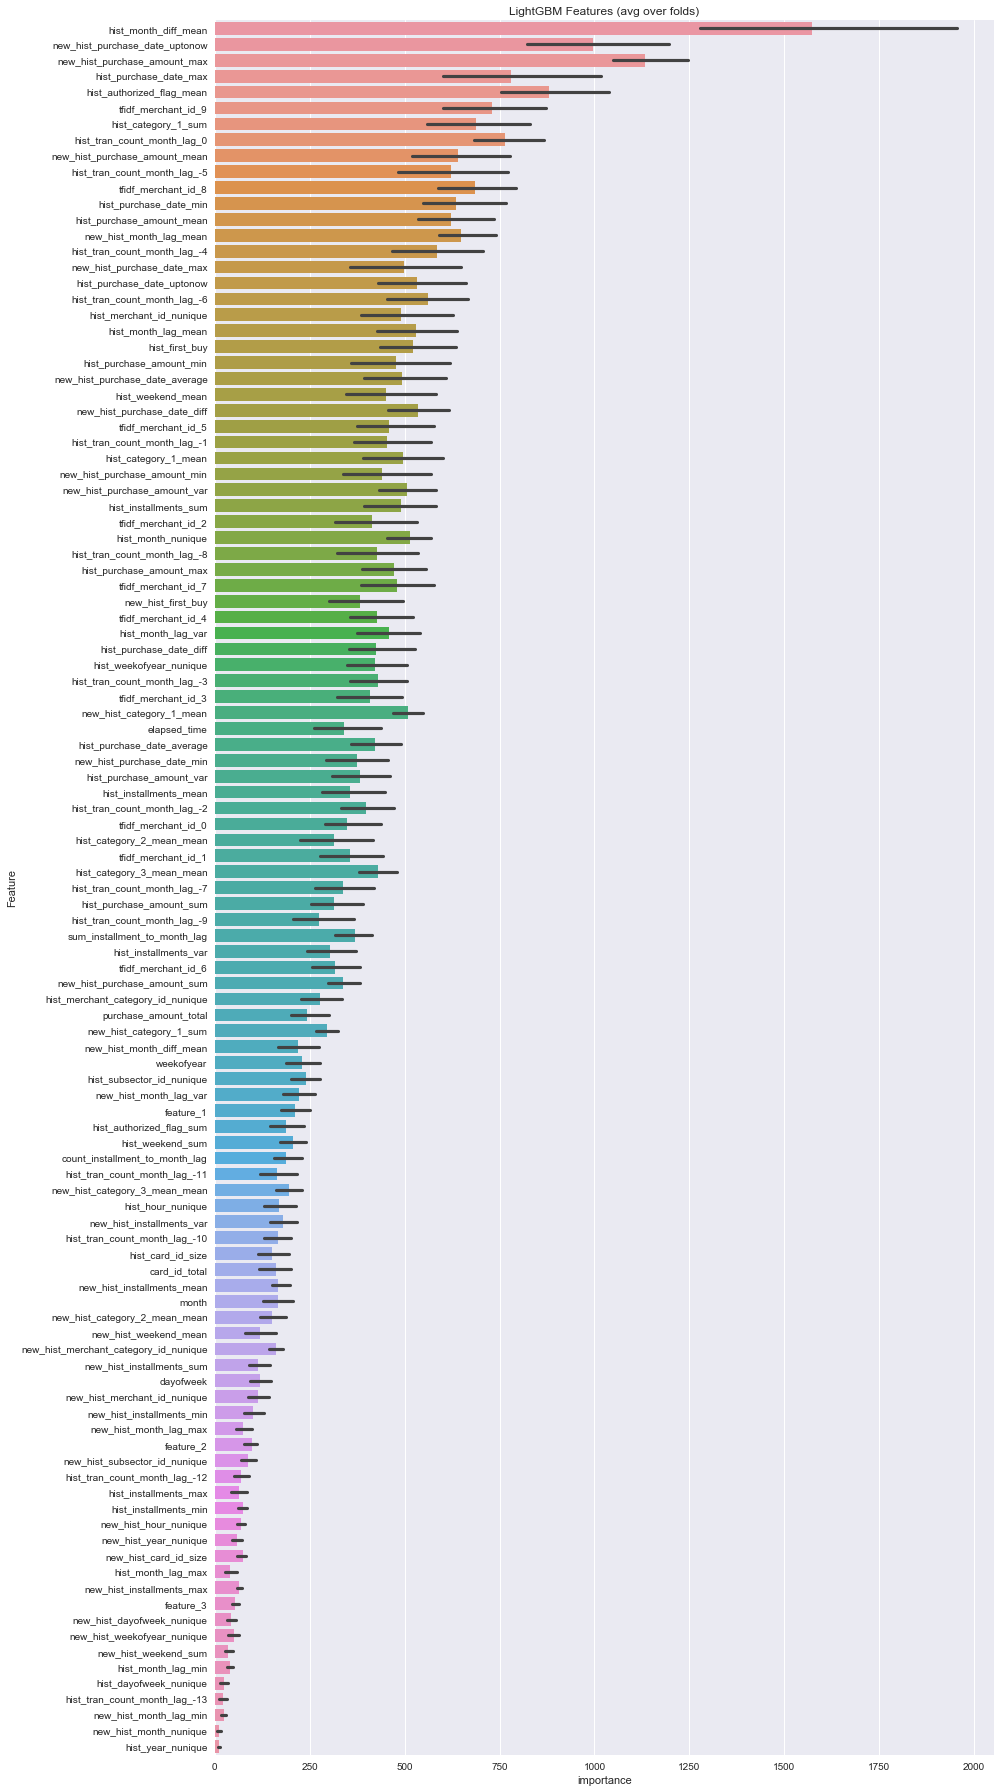

In [172]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [280]:
df_train_columns = ['feature_1',
                    'feature_2',
                    'feature_3',
                    'hist_month_nunique',
                    'hist_hour_nunique',
                    'hist_weekofyear_nunique',
                    'hist_dayofweek_nunique',
                    'hist_year_nunique',
                    'hist_subsector_id_nunique',
                    'hist_merchant_id_nunique',
                    'hist_merchant_category_id_nunique',
                    'hist_purchase_amount_sum',
                    'hist_purchase_amount_max',
                    'hist_purchase_amount_min',
                    'hist_purchase_amount_mean',
                    'hist_purchase_amount_var',
                    'hist_installments_sum',
                    'hist_installments_max',
                    'hist_installments_min',
                    'hist_installments_mean',
                    'hist_installments_var',
                    'hist_purchase_date_max',
                    'hist_purchase_date_min',
                    'hist_month_lag_max',
                    'hist_month_lag_min',
                    'hist_month_lag_mean',
                    'hist_month_lag_var',
                    'hist_month_diff_mean',
                    'hist_authorized_flag_sum',
                    'hist_authorized_flag_mean',
                    'hist_weekend_sum',
                    'hist_weekend_mean',
                    'hist_category_1_sum',
                    'hist_category_1_mean',
                    'hist_card_id_size',
                    'hist_category_2_mean_mean',
                    'hist_category_3_mean_mean',
                    'hist_purchase_date_diff',
                    'hist_purchase_date_average',
                    'hist_purchase_date_uptonow',
                    'new_hist_month_nunique',
                    'new_hist_hour_nunique',
                    'new_hist_weekofyear_nunique',
                    'new_hist_dayofweek_nunique',
                    'new_hist_year_nunique',
                    'new_hist_subsector_id_nunique',
                    'new_hist_merchant_id_nunique',
                    'new_hist_merchant_category_id_nunique',
                    'new_hist_purchase_amount_sum',
                    'new_hist_purchase_amount_max',
                    'new_hist_purchase_amount_min',
                    'new_hist_purchase_amount_mean',
                    'new_hist_purchase_amount_var',
                    'new_hist_installments_sum',
                    'new_hist_installments_max',
                    'new_hist_installments_min',
                    'new_hist_installments_mean',
                    'new_hist_installments_var',
                    'new_hist_purchase_date_max',
                    'new_hist_purchase_date_min',
                    'new_hist_month_lag_max',
                    'new_hist_month_lag_min',
                    'new_hist_month_lag_mean',
                    'new_hist_month_lag_var',
                    'new_hist_month_diff_mean',
                    'new_hist_weekend_sum',
                    'new_hist_weekend_mean',
                    'new_hist_category_1_sum',
                    'new_hist_category_1_mean',
                    'new_hist_card_id_size',
                    'new_hist_category_2_mean_mean',
                    'new_hist_category_3_mean_mean',
                    'new_hist_purchase_date_diff',
                    'new_hist_purchase_date_average',
                    'new_hist_purchase_date_uptonow',
                    'dayofweek',
                    'weekofyear',
                    'month',
                    'elapsed_time',
                    'hist_first_buy',
                    'new_hist_first_buy',
                    'card_id_total',
                    'purchase_amount_total'] + hist_month_lag_count_columns + tfidf_hist_merchant_columns + \
[
    'count_overdue',
# 'sum_overdue_month'
]

# df_train_columns.remove('hist_purchase_date_uptonow')
# df_train_columns.remove('tfidf_merchant_id_7')

In [279]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34499	valid_1's rmse: 3.64918
Early stopping, best iteration is:
[1525]	training's rmse: 3.25593	valid_1's rmse: 3.64694
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.33899	valid_1's rmse: 3.65422
Early stopping, best iteration is:
[1306]	training's rmse: 3.28349	valid_1's rmse: 3.65356
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.3461	valid_1's rmse: 3.6468
Early stopping, best iteration is:
[1451]	training's rmse: 3.26926	valid_1's rmse: 3.64431
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34176	valid_1's rmse: 3.65348
Early stopping, best iteration is:
[1574]	training's rmse: 3.24642	valid_1's rmse: 3.65047
fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[894]	training's rmse: 3.3606

3.6491640230578537

In [ ]:
fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34207	valid_1's rmse: 3.65351
Early stopping, best iteration is:
[1183]	training's rmse: 3.30879	valid_1's rmse: 3.65249
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.33742	valid_1's rmse: 3.65163
Early stopping, best iteration is:
[1169]	training's rmse: 3.30623	valid_1's rmse: 3.65113
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34343	valid_1's rmse: 3.64304
Early stopping, best iteration is:
[1568]	training's rmse: 3.24903	valid_1's rmse: 3.64099
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34151	valid_1's rmse: 3.65351
[2000]	training's rmse: 3.18477	valid_1's rmse: 3.64832
Early stopping, best iteration is:
[2097]	training's rmse: 3.17104	valid_1's rmse: 3.64779
fold 4
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.33408	valid_1's rmse: 3.65149
Early stopping, best iteration is:
[996]	training's rmse: 3.33514	valid_1's rmse: 3.65124
3.64872957602847



fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34321	valid_1's rmse: 3.65388
Early stopping, best iteration is:
[1217]	training's rmse: 3.3039	valid_1's rmse: 3.65288
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.3373	valid_1's rmse: 3.65026
Early stopping, best iteration is:
[1036]	training's rmse: 3.33053	valid_1's rmse: 3.65008
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34291	valid_1's rmse: 3.64485
Early stopping, best iteration is:
[1435]	training's rmse: 3.26875	valid_1's rmse: 3.64213
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34039	valid_1's rmse: 3.65341
[2000]	training's rmse: 3.18229	valid_1's rmse: 3.64883
Early stopping, best iteration is:
[2106]	training's rmse: 3.1674	valid_1's rmse: 3.64836
fold 4
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.33513	valid_1's rmse: 3.65233
Early stopping, best iteration is:
[996]	training's rmse: 3.33616	valid_1's rmse: 3.65204
3.6490987349017834

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.3421	valid_1's rmse: 3.6521
Early stopping, best iteration is:
[1225]	training's rmse: 3.30083	valid_1's rmse: 3.65093
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.33864	valid_1's rmse: 3.65149
Early stopping, best iteration is:
[1146]	training's rmse: 3.31195	valid_1's rmse: 3.6507
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34232	valid_1's rmse: 3.64355
Early stopping, best iteration is:
[1456]	training's rmse: 3.26464	valid_1's rmse: 3.64185
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34232	valid_1's rmse: 3.65434
[2000]	training's rmse: 3.18501	valid_1's rmse: 3.65006
Early stopping, best iteration is:
[2102]	training's rmse: 3.17102	valid_1's rmse: 3.64985
fold 4
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.33465	valid_1's rmse: 3.65298
Early stopping, best iteration is:
[980]	training's rmse: 3.3389	valid_1's rmse: 3.65252
3.6491724535230543

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34155	valid_1's rmse: 3.65428
Early stopping, best iteration is:
[1167]	training's rmse: 3.31069	valid_1's rmse: 3.65313
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.33759	valid_1's rmse: 3.65224
Early stopping, best iteration is:
[1333]	training's rmse: 3.27783	valid_1's rmse: 3.65184
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34264	valid_1's rmse: 3.64493
Early stopping, best iteration is:
[1566]	training's rmse: 3.2487	valid_1's rmse: 3.6428
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34048	valid_1's rmse: 3.65231
Early stopping, best iteration is:
[1630]	training's rmse: 3.23787	valid_1's rmse: 3.6489
fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[894]	training's rmse: 3.35539	valid_1's rmse: 3.65198
3.6497293357378457


fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34352	valid_1's rmse: 3.6536
Early stopping, best iteration is:
[1384]	training's rmse: 3.27645	valid_1's rmse: 3.65177
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.33938	valid_1's rmse: 3.65188
Early stopping, best iteration is:
[968]	training's rmse: 3.34584	valid_1's rmse: 3.6516
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34148	valid_1's rmse: 3.64647
Early stopping, best iteration is:
[1757]	training's rmse: 3.21869	valid_1's rmse: 3.64321
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34193	valid_1's rmse: 3.6539
Early stopping, best iteration is:
[1572]	training's rmse: 3.24688	valid_1's rmse: 3.65008
fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[881]	training's rmse: 3.35975	valid_1's rmse: 3.65148
    
3.6496305891595258

# RFE

In [267]:
def rfe_gbdt(params, train_x, train_y, full_vars, baseline_score=None, RFE_scores=[], kfold=5, train_kfold_y=train_kfold_y):
    original_params = copy.copy(lgb_params)
    train_vars = copy.copy(full_vars)

    if baseline_score is None:
        lgb_cv = lgb.cv(params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                folds=folds.split(train_x,train_kfold_y),## stratified kfolds based on outliers flag
                early_stopping_rounds=100,
                verbose_eval=-1)

        baseline_score = min(lgb_cv['rmse-mean'])
        RFE_scores = []
        RFE_scores.append(['baseline',  0, baseline_score])
    print ('Baseline score:', baseline_score)
    scores = []
    for v in train_vars:
        iter_train_vars = copy.copy(train_vars)
        iter_train_vars.remove(v)
        lgb_cv = lgb.cv(params,
                lgb.Dataset(train_x[iter_train_vars],
                            label=train_y
                            ),
                num_boost_round=100000,
                folds=folds.split(train_x[iter_train_vars],train_kfold_y),## stratified kfolds based on outliers flag
                early_stopping_rounds=100,
                verbose_eval=-1)

        iter_score = min(lgb_cv['rmse-mean'])
        scores.append([v, baseline_score, iter_score, iter_score - baseline_score])
        print('By eliminating %s, gain: %f, score:%f' %(v, iter_score - baseline_score, iter_score))
    scores = pd.DataFrame(scores)
    scores.columns = ['feature_name', 'baseline_score',  'score_by_elimination', 'gain_by_elimination']
    scores = scores.sort_values(by='gain_by_elimination', ascending=True)
    top_gain = scores['gain_by_elimination'].values[0]
    if top_gain<-0.0005:
        top_gain_var = scores['feature_name'].values[0]
        top_score = scores['score_by_elimination'].values[0]
        
        iter_vars = copy.copy(train_vars)
        
        if top_gain_var in iter_vars:
            iter_vars.remove(top_gain_var)

        print ('%s eliminated' % (top_gain_var))
        RFE_scores.append([top_gain_var, top_gain, top_score])
        print (RFE_scores)
        return rfe_gbdt(lgb_params, train_x, train_y, full_vars=train_vars,
                   baseline_score=top_score, RFE_scores=RFE_scores, train_kfold_y=train_kfold_y)
    else:
        top_gain_var = None
        return RFE_scores


In [281]:
train_x = df_train[df_train_columns]
train_y = df_train['target'].values

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 8,
         "random_state": 4590}

gc.collect()    
rfe_scores = rfe_gbdt(param, train_x, train_y, full_vars=df_train_columns, train_kfold_y=train_kfold_y )  

Baseline score: 3.648679774126544
By eliminating feature_1, gain: 0.001347, score:3.650026
By eliminating feature_2, gain: 0.000757, score:3.649437
By eliminating feature_3, gain: 0.002020, score:3.650699
By eliminating hist_month_nunique, gain: 0.005259, score:3.653938
By eliminating hist_hour_nunique, gain: 0.000514, score:3.649194
By eliminating hist_weekofyear_nunique, gain: 0.002146, score:3.650826
By eliminating hist_dayofweek_nunique, gain: 0.001128, score:3.649808
By eliminating hist_year_nunique, gain: 0.001755, score:3.650435
By eliminating hist_subsector_id_nunique, gain: 0.002460, score:3.651140
By eliminating hist_merchant_id_nunique, gain: 0.001339, score:3.650019
By eliminating hist_merchant_category_id_nunique, gain: 0.000548, score:3.649227
By eliminating hist_purchase_amount_sum, gain: 0.000931, score:3.649611
By eliminating hist_purchase_amount_max, gain: 0.001214, score:3.649894
By eliminating hist_purchase_amount_min, gain: 0.001228, score:3.649907
By eliminating h

In [271]:
df_train_columns = ['feature_1',
                    'feature_2',
                    'feature_3',
                    'hist_month_nunique',
                    'hist_hour_nunique',
                    'hist_weekofyear_nunique',
                    'hist_dayofweek_nunique',
                    'hist_year_nunique',
                    'hist_subsector_id_nunique',
                    'hist_merchant_id_nunique',
                    'hist_merchant_category_id_nunique',
                    'hist_purchase_amount_sum',
                    'hist_purchase_amount_max',
                    'hist_purchase_amount_min',
                    'hist_purchase_amount_mean',
                    'hist_purchase_amount_var',
                    'hist_installments_sum',
                    'hist_installments_max',
                    'hist_installments_min',
                    'hist_installments_mean',
                    'hist_installments_var',
                    'hist_purchase_date_max',
                    'hist_purchase_date_min',
                    'hist_month_lag_max',
                    'hist_month_lag_min',
                    'hist_month_lag_mean',
                    'hist_month_lag_var',
                    'hist_month_diff_mean',
                    'hist_authorized_flag_sum',
                    'hist_authorized_flag_mean',
                    'hist_weekend_sum',
                    'hist_weekend_mean',
                    'hist_category_1_sum',
                    'hist_category_1_mean',
                    'hist_card_id_size',
                    'hist_category_2_mean_mean',
                    'hist_category_3_mean_mean',
                    'hist_purchase_date_diff',
                    'hist_purchase_date_average',
                    'hist_purchase_date_uptonow',
                    'new_hist_month_nunique',
                    'new_hist_hour_nunique',
                    'new_hist_weekofyear_nunique',
                    'new_hist_dayofweek_nunique',
                    'new_hist_year_nunique',
                    'new_hist_subsector_id_nunique',
                    'new_hist_merchant_id_nunique',
                    'new_hist_merchant_category_id_nunique',
                    'new_hist_purchase_amount_sum',
                    'new_hist_purchase_amount_max',
                    'new_hist_purchase_amount_min',
                    'new_hist_purchase_amount_mean',
                    'new_hist_purchase_amount_var',
                    'new_hist_installments_sum',
                    'new_hist_installments_max',
                    'new_hist_installments_min',
                    'new_hist_installments_mean',
                    'new_hist_installments_var',
                    'new_hist_purchase_date_max',
                    'new_hist_purchase_date_min',
                    'new_hist_month_lag_max',
                    'new_hist_month_lag_min',
                    'new_hist_month_lag_mean',
                    'new_hist_month_lag_var',
                    'new_hist_month_diff_mean',
                    'new_hist_weekend_sum',
                    'new_hist_weekend_mean',
                    'new_hist_category_1_sum',
                    'new_hist_category_1_mean',
                    'new_hist_card_id_size',
                    'new_hist_category_2_mean_mean',
                    'new_hist_category_3_mean_mean',
                    'new_hist_purchase_date_diff',
                    'new_hist_purchase_date_average',
                    'new_hist_purchase_date_uptonow',
                    'dayofweek',
                    'weekofyear',
                    'month',
                    'elapsed_time',
                    'hist_first_buy',
                    'new_hist_first_buy',
                    'card_id_total',
                    'purchase_amount_total'] 

In [272]:
train_x = df_train[df_train_columns[::-1]]
train_y = df_train['target'].values

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.05,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 8,
         "random_state": 4590}

gc.collect()    
rfe_scores_1 = rfe_gbdt(param, train_x, train_y, full_vars=df_train_columns[::-1], train_kfold_y=train_kfold_y )  

Baseline score: 3.6588081785706095
By eliminating purchase_amount_total, gain: 0.002665, score:3.661473
By eliminating card_id_total, gain: 0.001864, score:3.660673
By eliminating new_hist_first_buy, gain: 0.001573, score:3.660382
By eliminating hist_first_buy, gain: 0.001048, score:3.659856
By eliminating elapsed_time, gain: -0.000012, score:3.658796
By eliminating month, gain: -0.000971, score:3.657837
By eliminating weekofyear, gain: -0.000116, score:3.658692
By eliminating dayofweek, gain: 0.001366, score:3.660174
By eliminating new_hist_purchase_date_uptonow, gain: -0.000716, score:3.658093
By eliminating new_hist_purchase_date_average, gain: 0.003411, score:3.662219
By eliminating new_hist_purchase_date_diff, gain: 0.002621, score:3.661429
By eliminating new_hist_category_3_mean_mean, gain: 0.000761, score:3.659569
By eliminating new_hist_category_2_mean_mean, gain: 0.002141, score:3.660949
By eliminating new_hist_card_id_size, gain: 0.001607, score:3.660415
By eliminating new_hi

By eliminating new_hist_purchase_amount_mean, gain: -0.007465, score:3.648620
By eliminating new_hist_purchase_amount_min, gain: -0.007828, score:3.648257
By eliminating new_hist_purchase_amount_max, gain: -0.008287, score:3.647798
By eliminating new_hist_purchase_amount_sum, gain: -0.008149, score:3.647936
By eliminating new_hist_merchant_category_id_nunique, gain: -0.008129, score:3.647955
By eliminating new_hist_merchant_id_nunique, gain: -0.008164, score:3.647921
By eliminating new_hist_subsector_id_nunique, gain: -0.008264, score:3.647820
By eliminating new_hist_year_nunique, gain: -0.007868, score:3.648216
By eliminating new_hist_dayofweek_nunique, gain: -0.008469, score:3.647615
By eliminating new_hist_weekofyear_nunique, gain: -0.008089, score:3.647996
By eliminating new_hist_hour_nunique, gain: -0.007954, score:3.648130
By eliminating new_hist_month_nunique, gain: -0.008050, score:3.648034
By eliminating hist_purchase_date_uptonow, gain: -0.007972, score:3.648112
By eliminatin

By eliminating hist_purchase_date_min, gain: 0.001431, score:3.649046
By eliminating hist_purchase_date_max, gain: 0.000914, score:3.648529
By eliminating hist_installments_var, gain: 0.000875, score:3.648490
By eliminating hist_installments_mean, gain: 0.001037, score:3.648652
By eliminating hist_installments_min, gain: 0.001013, score:3.648628
By eliminating hist_installments_max, gain: 0.000701, score:3.648316
By eliminating hist_installments_sum, gain: 0.001248, score:3.648863
By eliminating hist_purchase_amount_var, gain: 0.000633, score:3.648248
By eliminating hist_purchase_amount_mean, gain: 0.000909, score:3.648524
By eliminating hist_purchase_amount_min, gain: 0.001182, score:3.648797
By eliminating hist_purchase_amount_max, gain: 0.000869, score:3.648484
By eliminating hist_purchase_amount_sum, gain: 0.000994, score:3.648609
By eliminating hist_merchant_category_id_nunique, gain: 0.000874, score:3.648489
By eliminating hist_merchant_id_nunique, gain: 0.001455, score:3.649070


In [277]:
pd.options.display.float_format = '{:,.4f}'.format
all_retained_vars = list(set(df_train_columns[::-1]) - set(pd.DataFrame(rfe_scores_1, columns=['feature_name', 'gain', 'score']).feature_name))
print ('retained features:', all_retained_vars)
pd.DataFrame(rfe_scores, columns=['feature_name', 'gain', 'score'])



retained features: ['hist_authorized_flag_mean', 'tfidf_merchant_id_9', 'hist_tran_count_month_lag_-4', 'new_hist_installments_min', 'new_hist_installments_mean', 'feature_2', 'tfidf_merchant_id_1', 'dayofweek', 'new_hist_purchase_amount_min', 'hist_subsector_id_nunique', 'hist_tran_count_month_lag_-1', 'new_hist_month_lag_var', 'tfidf_merchant_id_2', 'hist_month_lag_min', 'new_hist_hour_nunique', 'hist_installments_var', 'new_hist_month_lag_min', 'hist_purchase_amount_mean', 'feature_3', 'hist_tran_count_month_lag_-5', 'new_hist_purchase_date_uptonow', 'hist_merchant_id_nunique', 'hist_authorized_flag_sum', 'hist_month_lag_mean', 'new_hist_purchase_amount_max', 'hist_merchant_category_id_nunique', 'new_hist_weekend_sum', 'hist_month_diff_mean', 'tfidf_merchant_id_6', 'count_overdue', 'elapsed_time', 'new_hist_category_3_mean_mean', 'hist_month_lag_max', 'tfidf_merchant_id_3', 'hist_purchase_amount_max', 'hist_tran_count_month_lag_-12', 'hist_dayofweek_nunique', 'new_hist_purchase_amou

,feature_name,gain,score
0,baseline,0.0000,3.6556
1,hist_purchase_date_uptonow,-0.0037,3.6519
2,tfidf_merchant_id_7,-0.0071,3.6448


# Parameter tuning

## LightGBM

### Manual tuning

* Find the best value for a parameter then move to the next one.
* Repeat the process for all the parameters we want to tune.
* Tuning with a larger learning rate 0.1

In [103]:
train_x = df_train[df_train_columns].values
train_y = target.values
test_x = df_test[df_train_columns].values
train_kfold_y = df_train['outliers'].values

In [104]:
import copy
default_lgb_params = {}
default_lgb_params["learning_rate"] = 0.05
default_lgb_params["metric"] = 'rmse'
default_lgb_params["bagging_freq"] = 1
default_lgb_params["seed"] = 1234
default_lgb_params["objective"] = "regression"
default_lgb_params["n_jobs"] = 8

params_lgb_space = {}
params_lgb_space['num_leaves'] = [3, 7, 15, 31, 63, 127, 255]
params_lgb_space['max_depth'] = [3, 5, 7, 10, 15, 30, -1]
params_lgb_space['min_gain_to_split'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_lgb_space['feature_fraction'] = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]
params_lgb_space['bagging_fraction'] = [0.6, 0.7, 0.8, 0.9, 0.95, 1]
params_lgb_space['min_sum_hessian_in_leaf'] = [1, 5, 10, 30, 100]
params_lgb_space['lambda_l2'] = [0, 0.01, 0.1, 1, 10, 100, 300]
params_lgb_space['lambda_l1'] = [0, 0.01, 0.1, 1, 10, 100, 300]


greater_is_better = False

best_lgb_params = copy.copy(default_lgb_params)

for p in params_lgb_space:
    print ("\n Tuning parameter %s in %s" % (p, params_lgb_space[p]))

    params = best_lgb_params
    scores = []    
    for v in params_lgb_space[p]:
        print ('\n    %s: %s' % (p, v), end="\n")
        params[p] = v
        lgb_cv = lgb.cv(params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                folds=folds.split(train_x,train_kfold_y),## stratified kfolds based on outliers flag
                early_stopping_rounds=100,
                verbose_eval=-1)

        best_lgb_score = min(lgb_cv['rmse-mean'])
        best_lgb_iteration = len(lgb_cv['rmse-mean'])
        print (', best_score: %f, best_iteration: %d' % (best_lgb_score, best_lgb_iteration))
        scores.append([v, best_lgb_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_lgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('\n Best manually tuned parameters:', best_lgb_params)   

best_manual_lgb_params = copy.copy(best_lgb_params)


 Tuning parameter num_leaves in [3, 7, 15, 31, 63, 127, 255]

    num_leaves: 3


KeyboardInterrupt: 

### Auto tuning

We will be using a package BayesianOptimization for automated tuning. Results from manual tuning can be used to further narrow the space that needs to be searched from for better performance. 

Visit https://github.com/fmfn/BayesianOptimization for more details about Bayesian Optimization.

In [33]:
from bayes_opt import BayesianOptimization


def lgb_evaluate(
    num_leaves,
    max_depth,
    min_sum_hessian_in_leaf,
    min_gain_to_split,
    feature_fraction,
    bagging_fraction,
    lambda_l2,
    lambda_l1
):
    params = dict()
    params['objective'] = 'regression'
    params['learning_rate'] = 0.05
    params['seed'] = 1234
    params['num_leaves'] = int(num_leaves)
    params['max_depth'] = int(max_depth)
    params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
    params['min_gain_to_split'] = min_gain_to_split
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = 1
    params['lambda_l2'] = lambda_l2
    params['lambda_l1'] = lambda_l1
    params["metric"] = 'rmse'
    params["n_jobs"] = 8

    lgb_cv = lgb.cv(params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                folds=folds.split(train_x,train_kfold_y),## stratified kfolds based on outliers flag
                early_stopping_rounds=100,
                verbose_eval=-1)

    best_lgb_score = min(lgb_cv['rmse-mean'])
    best_lgb_iteration = len(lgb_cv['rmse-mean'])
    print(', best_score: %f, best_iteration: %d' %
          (best_lgb_score, best_lgb_iteration))

    return -best_lgb_score


lgb_BO = BayesianOptimization(lgb_evaluate,
                               {
                                  'num_leaves': (5, 30),
                                  'max_depth': (3, 15),
                                  'min_sum_hessian_in_leaf': (10, 300),
                                  'min_gain_to_split': (1, 10),
                                  'feature_fraction': (0.6, 1),
                                  'bagging_fraction': (0.6, 1),
                                  'lambda_l2': (100, 500),
                                  'lambda_l1': (0, 50)
                              }
                              )

lgb_BO.maximize(init_points=5, n_iter=40)

Initialization
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_gain_to_split |   min_sum_hessian_in_leaf |   num_leaves | 
, best_score: 3.647610, best_iteration: 665
    1 | 00m38s |   -3.64761 |             0.9247 |             0.7935 |     25.9347 |    424.6334 |     14.9598 |              2.8934 |                  261.3086 |      19.9064 | 
, best_score: 3.647508, best_iteration: 965
    2 | 00m42s |   -3.64751 |             0.8009 |             0.9694 |     29.5086 |    168.4595 |     10.5229 |              5.8502 |                  248.3911 |       9.7282 | 
, best_score: 3.649032, best_iteration: 440
    3 | 00m25s |   -3.64903 |             0.6032 |             0.6784 |     48.2397 |    383.2992 |     11.4533 |              7.2229 

, best_score: 3.649315, best_iteration: 290
   33 | 00m40s |   -3.64931 |             0.6139 |             0.9886 |     37.2818 |    206.8026 |     14.9343 |              1.0562 |                  212.8627 |      29.3566 | 
, best_score: 3.648593, best_iteration: 400
   34 | 00m38s |   -3.64859 |             0.7223 |             0.6258 |     47.9470 |    376.0271 |     14.6358 |              9.7137 |                  227.0989 |      29.3797 | 
, best_score: 3.650949, best_iteration: 1769
   35 | 01m03s |   -3.65095 |             0.7653 |             0.7326 |      1.0479 |    265.5392 |     14.9156 |              7.3356 |                   83.9233 |       5.5034 | 
, best_score: 3.650045, best_iteration: 409
   36 | 00m54s |   -3.65005 |             0.9896 |             0.9790 |      6.7795 |    143.8659 |     14.6023 |              1.8823 |                   22.7511 |      28.8701 | 
, best_score: 3.648323, best_iteration: 904
   37 | 00m53s |   -3.64832 |             0.6966 |         

#### Results of auto tuning:

In [34]:
# gc.collect()

lgb_BO_scores = pd.DataFrame(lgb_BO.res['all']['params'])
lgb_BO_scores['score'] = pd.DataFrame(lgb_BO.res['all']['values'])
lgb_BO_scores = lgb_BO_scores.sort_values(by='score',ascending=False)

lgb_BO_scores.to_csv("../python/tuned_lgb_parameters.csv", index=False)
lgb_BO_scores.head()

,bagging_fraction,feature_fraction,lambda_l1,lambda_l2,max_depth,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,score
8,0.947570,0.843669,2.047843,315.649431,14.951110,8.908745,126.633437,29.317638,-3.645446
23,0.984434,0.623695,48.644871,495.768962,14.682210,1.643156,261.199928,29.256036,-3.646536
14,0.944607,0.822274,49.623750,498.991242,14.519697,5.870146,12.196652,28.102246,-3.646728
26,0.799356,0.957321,41.520483,235.406177,14.551647,9.448550,10.285932,29.215174,-3.646732
25,0.924920,0.838093,0.480310,307.212086,14.856124,1.331801,13.472388,23.800770,-3.646784


### Retrain the model with smaller learning rate

In [35]:
params = lgb_BO_scores.iloc[0].to_dict()
best_lgb_params = dict()
best_lgb_params['objective'] = 'regression'
best_lgb_params["metric"] = 'rmse'
best_lgb_params['learning_rate'] = 0.01 # Smaller learning rate
best_lgb_params['num_leaves'] = int(params['num_leaves'])    
best_lgb_params['max_depth'] = int(params['max_depth'])    
best_lgb_params['min_sum_hessian_in_leaf'] = params['min_sum_hessian_in_leaf']
best_lgb_params['min_gain_to_split'] = params['min_gain_to_split']     
best_lgb_params['feature_fraction'] = params['feature_fraction']
best_lgb_params['bagging_fraction'] = params['bagging_fraction']
best_lgb_params['bagging_freq'] = 1
best_lgb_params['lambda_l2'] = params['lambda_l2']
best_lgb_params['lambda_l1'] = params['lambda_l1']
best_lgb_params['random_state'] = 4590
best_lgb_params["n_jobs"] = 8



folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(best_lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.53664	valid_1's rmse: 3.64692
[2000]	training's rmse: 3.45399	valid_1's rmse: 3.64284
Early stopping, best iteration is:
[2395]	training's rmse: 3.4253	valid_1's rmse: 3.6418
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.53627	valid_1's rmse: 3.64734
[2000]	training's rmse: 3.45469	valid_1's rmse: 3.64349
Early stopping, best iteration is:
[1947]	training's rmse: 3.45848	valid_1's rmse: 3.64333
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.53403	valid_1's rmse: 3.64714
[2000]	training's rmse: 3.45328	valid_1's rmse: 3.64077
Early stopping, best iteration is:
[2220]	training's rmse: 3.43751	valid_1's rmse: 3.64037
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.53308	valid_1's rmse: 3.65318
[2000]	training's rmse: 3.45433	valid_1's rmse: 3.64562
[

3.6438390312666034

In [37]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("sub_lgb_tuned.csv", index=False)

## XGBoost

### Manual tuning

In [46]:
import xgboost as xgb
default_xgb_params = {}
default_xgb_params["objective"] = "reg:linear"
default_xgb_params["eta"] = 0.05
default_xgb_params["seed"] = 1234

params_xgb_space = {}
params_xgb_space['max_depth'] = [4, 5, 6, 7, 8, 9, 10]
params_xgb_space['gamma'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_xgb_space['colsample_bytree'] = [
    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_xgb_space['subsample'] = [
    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_xgb_space['min_child_weight'] = [0, 1, 3, 10, 30, 100]
params_xgb_space['reg_lambda'] = [0, 0.01, 0.1, 1, 10, 100, 300]
params_xgb_space['reg_alpha'] = [0, 0.01, 0.1, 1, 10, 100]

greater_is_better = False

xgtrain = xgb.DMatrix(train_x, label=train_y)
kfolds_list = [(i[0], i[1]) for i in folds.split(train_x, train_kfold_y)]

best_xgb_params = default_xgb_params
for p in params_xgb_space:
    print("Tuning parameter %s in %s" % (p, params_xgb_space[p]))

    params = best_xgb_params
    scores = []
    for v in params_xgb_space[p]:
        print('    %s: %s' % (p, v), end="")
        params[p] = v
        cv_results = xgb.cv(params,
                            xgtrain,
                            stratified=False,
                            folds=kfolds_list,
                            num_boost_round=100000,
                            early_stopping_rounds=100,
                            verbose_eval=False)
        best_iteration = len(cv_results)
        best_score = cv_results['test-rmse-mean'].min()
        print(', best_score: %f, best_iteration: %d' %
              (best_score, best_iteration))
        scores.append([v, best_score])
    # best param value in the space
    best_param_value = sorted(
        scores, key=lambda x: x[1], reverse=greater_is_better)[0][0]
    best_param_score = sorted(
        scores, key=lambda x: x[1], reverse=greater_is_better)[0][1]
    best_xgb_params[p] = best_param_value
    print("Best %s is %s with a score of %f" %
          (p, best_param_value, best_param_score))

Tuning parameter max_depth in [4, 5, 6, 7, 8, 9, 10]
    max_depth: 4, best_score: 3.666444, best_iteration: 346
    max_depth: 5, best_score: 3.659723, best_iteration: 211
    max_depth: 6, best_score: 3.659962, best_iteration: 149
    max_depth: 7, best_score: 3.660746, best_iteration: 155
    max_depth: 8, best_score: 3.667699, best_iteration: 103
    max_depth: 9, best_score: 3.675081, best_iteration: 77
    max_depth: 10, best_score: 3.683763, best_iteration: 59
Best max_depth is 5 with a score of 3.659723
Tuning parameter gamma in [0, 0.1, 0.3, 1, 1.5, 2, 3]
    gamma: 0, best_score: 3.659723, best_iteration: 211
    gamma: 0.1, best_score: 3.659208, best_iteration: 268
    gamma: 0.3, best_score: 3.659952, best_iteration: 241
    gamma: 1, best_score: 3.659125, best_iteration: 252
    gamma: 1.5, best_score: 3.658957, best_iteration: 274
    gamma: 2, best_score: 3.659547, best_iteration: 247
    gamma: 3, best_score: 3.659136, best_iteration: 228
Best gamma is 1.5 with a score 

In [47]:
print ('\n Best manually tuned parameters:', best_xgb_params)   

best_manual_xgb_params = copy.copy(best_xgb_params)


 Best manually tuned parameters: {'objective': 'reg:linear', 'eta': 0.05, 'seed': 1234, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 0.5, 'subsample': 1, 'min_child_weight': 100, 'reg_lambda': 300, 'reg_alpha': 10}


### Auto tuning

In [49]:
def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 reg_lambda,
                 reg_alpha):
    params = dict()
    params['objective'] = 'reg:linear'
    params['eta'] = 0.05
    params['max_depth'] = int(max_depth)
    params['min_child_weight'] = min_child_weight
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['reg_lambda'] = reg_lambda
    params['reg_alpha'] = reg_alpha
    params['seed'] = 1234

    cv_results = xgb.cv(params,
                        xgtrain,
                        stratified=False,
                        folds=kfolds_list,
                        num_boost_round=100000,
                        early_stopping_rounds=100,
                        verbose_eval=False)
    best_iteration = len(cv_results)
    best_score = cv_results['test-rmse-mean'].min()

    print(', best_score: %f, best_iteration: %d' %
          (best_score, best_iteration))

    return -best_score


xgb_BO = BayesianOptimization(xgb_evaluate,
                              {'max_depth': (3, 9),
                               'min_child_weight': (30, 300),
                               'colsample_bytree': (0.5, 1),
                               'subsample': (0.7, 1),
                               'gamma': (0, 5),
                               'reg_lambda': (200, 1000),
                               'reg_alpha': (0, 100)
                               }
                              )

xgb_BO.maximize(init_points=5, n_iter=35)

Initialization
--------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   reg_alpha |   reg_lambda |   subsample | 
, best_score: 3.654687, best_iteration: 1707
    1 | 11m21s |   -3.65469 |             0.6457 |    0.8152 |      3.0631 |           230.9502 |     97.0960 |     428.9329 |      0.7573 | 
, best_score: 3.656255, best_iteration: 1675
    2 | 10m27s |   -3.65626 |             0.5721 |    4.5469 |      3.9963 |           260.8175 |     73.2269 |     396.5418 |      0.9706 | 
, best_score: 3.649153, best_iteration: 1081
    3 | 10m37s |   -3.64915 |             0.7481 |    1.4453 |      4.1666 |           162.9377 |     49.2516 |     774.5857 |      0.8152 | 
, best_score: 3.647502, best_iteration: 698
    4 | 08m06s |   -3.64750 |             0.6788 |    0.9310 |      5.8158 |           181.5482 |

, best_score: 3.647028, best_iteration: 327
   40 | 08m29s |   -3.64703 |             0.8620 |    4.0371 |      8.8174 |           143.9794 |      1.1603 |     418.5156 |      0.7648 | 


In [50]:
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores.head()

,colsample_bytree,gamma,max_depth,min_child_weight,reg_alpha,reg_lambda,subsample,score
27,0.572737,4.838619,8.925510,115.667442,4.957305,346.615700,0.890880,-3.645109
2,0.820863,3.866133,7.643908,30.487439,2.368676,595.674087,0.918031,-3.645304
30,0.584128,3.988715,8.627518,30.218023,96.499087,312.319496,0.911187,-3.645632
17,0.896460,4.359080,8.951727,294.881150,1.249141,803.519412,0.910179,-3.646120
21,0.665100,0.177316,8.974627,112.593347,84.657339,364.577075,0.791997,-3.646248


### Retrain the model with smaller learning rate

In [54]:
gc.collect()
best_xgb_params = xgb_BO_scores.iloc[0].to_dict()
best_xgb_params['objective'] = 'reg:linear'
best_xgb_params['eta'] = 0.01  # Smaller

best_xgb_params['max_depth'] = int(best_xgb_params['max_depth'])
best_xgb_params['min_child_weight'] = best_xgb_params['min_child_weight']
best_xgb_params['subsample'] = best_xgb_params['subsample']
best_xgb_params['colsample_bytree'] = best_xgb_params['colsample_bytree']
best_xgb_params['gamma'] = best_xgb_params['gamma']
best_xgb_params['reg_lambda'] = best_xgb_params['reg_lambda']
best_xgb_params['reg_alpha'] = best_xgb_params['reg_alpha']
best_xgb_params['seed'] = 1234



oof_xgb = np.zeros(len(df_train))
predictions_xgb = np.zeros(len(df_test))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    
    trn_data = xgb.DMatrix(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = xgb.DMatrix(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])
    
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    xgb_model = xgb.train(best_xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(df_train.iloc[val_idx][df_train_columns]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb += xgb_model.predict(xgb.DMatrix(df_test[df_train_columns]), ntree_limit=xgb_model.best_ntree_limit+50) / folds.n_splits
    
np.save('oof_xgb', oof_xgb)
np.save('predictions_xgb', predictions_xgb)
np.sqrt(mean_squared_error(target.values, oof_xgb))

-
Fold 1
xgb 0--------------------------------------------------
[0]	train-rmse:3.94607	valid-rmse:3.95898
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1000]	train-rmse:3.48055	valid-rmse:3.64638
Stopping. Best iteration:
[1537]	train-rmse:3.41921	valid-rmse:3.6435

-
Fold 2
xgb 1--------------------------------------------------
[0]	train-rmse:3.94895	valid-rmse:3.94731
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1000]	train-rmse:3.47389	valid-rmse:3.64221
Stopping. Best iteration:
[1218]	train-rmse:3.44941	valid-rmse:3.64129

-
Fold 3
xgb 2--------------------------------------------------
[0]	train-rmse:3.94658	valid-rmse:3.95727
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1000]	trai

3.6438252036924412

In [56]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions_xgb
sub_df.to_csv("sub_xgb_tuned.csv", index=False)

# Quick ensemble

Let's create a quick ensemble by averaging the submissions generated by LightGBM and XGBoost

In [58]:
np.sqrt(mean_squared_error(target.values, oof_xgb*0.5 + oof*0.5))

3.64270246181885

In [57]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions_xgb*0.5 + predictions*0.5
sub_df.to_csv("sub_tuned_xgb_lgb.csv", index=False)

# Conclusions
Paramter tuning plays an important role in practical data science. In this we've learnt:

1. A framework that can be used to guide parameter turnings
2. XGBoost and LightGBM hypter-parameters
3. Manual tuning
4. Automated tuning


# References
* [XGBoost Parameters](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md)
* [XGBoost official tuning guide](http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html)
* [Tianqi Chen’s guide on XGBoost in Chinese](http://www.52cs.org/?p=429)
* [MachineLearningMastery’s XGBoost tutorials](http://machinelearningmastery.com/category/xgboost/)
* [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
* [What to optimize first? Gamma or Depth? What’s up with min_child_weight?](https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6)
* [LightGBM Parameters](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst)
* [Parameters Tuning](http://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
* [CatBoost vs. Light GBM vs. XGBoost](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)

# Stacking

Below is an end-to-end example demonstrating how stacking works. However for Time-Series problems stacking may not be a good choice and you may want to use it with discretion.


1. Create 3 LightGBM models with top 3 tuned parameters  
2. Create 3 XGBoost models with top 3 tuned parameters
3. Create out-of-fold predictions for the above 6 models (Level 1)
4. Train a Rigde Regressor as level 2 model with level 1 features only

## Define stacking functions

In [59]:
import copy

def lgb_rgr_stack(rgr_params, train_x, train_y, test_x, kfolds, stratified=False,  random_state=42,
                  early_stopping_rounds=0, missing=None, full_vars=None, cat_vars=None, y_dummy=None):
    if stratified:
        kf = StratifiedKFold(n_splits=kfolds, shuffle=True,
                             random_state=random_state)
        kf_ids = list(kf.split(train_x, y_dummy))
    else:
        kf = KFold(n_splits=kfolds, random_state=random_state)
        kf_ids = list(kf.split(train_y))

    train_blend_x = np.zeros((train_x.shape[0], len(rgr_params)))
    test_blend_x = np.zeros((test_x.shape[0], len(rgr_params)))
    blend_scores = np.zeros((kfolds, len(rgr_params)))

    print("Start stacking.")
    for j, params in enumerate(rgr_params):
        print("Stacking model", j+1, params)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(kf_ids):
            start = time.time()
            print("Model %d fold %d" % (j+1, i+1))
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            print(i, params)

            train_dataset = lgb.Dataset(train_x_fold,
                                        train_y_fold,
                                        feature_name=full_vars,
                                        categorical_feature=cat_vars
                                        )
            valid_dataset = lgb.Dataset(val_x_fold,
                                        val_y_fold,
                                        feature_name=full_vars,
                                        categorical_feature=cat_vars
                                        )

            if early_stopping_rounds == 0:
                num_boost_round = copy.deepcopy(params['num_boost_round'])
                model = lgb.train(params,
                                  train_dataset,
                                  num_boost_round=num_boost_round,
                                  verbose_eval=500
                                  )
                val_y_predict_fold = model.predict(val_x_fold)
                score = np.sqrt(mean_squared_error(
                    val_y_fold, val_y_predict_fold))
                print("Score for Model %d fold %d: %f " % (j+1, i+1, score))
                blend_scores[i, j] = score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(test_x)
                print("Model %d fold %d finished in %d seconds." %
                      (j+1, i+1, time.time()-start))
            else:
                model = lgb.train(params,
                                  train_dataset,
                                  valid_sets=[train_dataset, valid_dataset],
                                  valid_names=['train', 'valid'],
                                  num_boost_round=10000000,
                                  early_stopping_rounds=early_stopping_rounds,
                                  verbose_eval=1000
                                  )
                best_iteration = model.best_iteration
                print(model.best_score['valid']['rmse'])
                val_y_predict_fold = model.predict(
                    val_x_fold, num_iteration=best_iteration)
                score = np.sqrt(mean_squared_error(
                    val_y_fold, val_y_predict_fold))
                print("Score for Model %d fold %d: %f " % (j+1, i+1, score))
                blend_scores[i, j] = score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + \
                    model.predict(test_x, num_iteration=best_iteration)
                print("Model %d fold %d finished in %d seconds." %
                      (j+1, i+1, time.time()-start))

        test_blend_x[:, j] = test_blend_x_j/kfolds
        print("Score for model %d is %f" % (j+1, np.mean(blend_scores[:, j])))
    return train_blend_x, test_blend_x, blend_scores


def sk_rgr_stack(models, train_x, train_y, test_x, kfolds, random_state=42, verbose_eval=1, stratified=False, y_dummy=None):

    if stratified:
        kf = StratifiedKFold(n_splits=kfolds, shuffle=True,
                             random_state=random_state)
        kf_ids = list(kf.split(train_x, y_dummy))
    else:
        kf = KFold(n_splits=kfolds, random_state=random_state)
        kf_ids = kf.split(train_y)
    
    train_blend_x = np.zeros((train_x.shape[0], len(models)))
    test_blend_x = np.zeros((test_x.shape[0], len(models)))
    blend_scores = np.zeros ((kfolds,len(models)))
    
    if verbose_eval>0:
        print  ("Start stacking.")
    for j, model in enumerate(models):
        if verbose_eval>0:
            print ("Stacking model",j+1, model)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(kf_ids):
            start = time.time()
            if verbose_eval>0:
                print ("Model %d fold %d" %(j+1,i+1))
            train_x_fold = train_x[train_ids,:]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids,:]
            val_y_fold = train_y[val_ids]
            if verbose_eval>0:
                print (i, model)
            
            model.fit(train_x_fold, train_y_fold)
            val_y_predict_fold = model.predict(val_x_fold)
            score = np.sqrt(mean_squared_error(val_y_fold,val_y_predict_fold))
            if verbose_eval>0:
                print ("Score for Model %d fold %d: %f " % (j+1,i+1,score))
            blend_scores[i,j]=score
            train_blend_x[val_ids, j] = val_y_predict_fold
            test_blend_x_j = test_blend_x_j + model.predict(test_x)
            if verbose_eval>0:
                print ("Model %d fold %d finished in %d seconds." % (j+1,i+1, time.time()-start))
                  
        test_blend_x[:,j] = test_blend_x_j/kfolds
        if verbose_eval>0:
            print ("Score for model %d is %f" % (j+1,np.mean(blend_scores[:,j])))
    return train_blend_x, test_blend_x, blend_scores   


def xgb_rgr_stack(rgr_params, train_x, train_y, test_x, kfolds, stratified=False,  random_state=42,
                  early_stopping_rounds=0, missing=None, full_vars=None, cat_vars=None, y_dummy=None):
    if stratified:
        kf = StratifiedKFold(n_splits=kfolds, shuffle=True,
                             random_state=random_state)
        kf_ids = list(kf.split(train_x, y_dummy))
    else:
        kf = KFold(n_splits=kfolds, random_state=random_state)
        kf_ids = list(kf.split(train_y))

    train_blend_x = np.zeros((train_x.shape[0], len(rgr_params)))
    test_blend_x = np.zeros((test_x.shape[0], len(rgr_params)))
    blend_scores = np.zeros((kfolds, len(rgr_params)))
    
    test_dataset = xgb.DMatrix(test_x)

    print("Start stacking.")
    for j, params in enumerate(rgr_params):
        print("Stacking model", j+1, params)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(kf_ids):
            start = time.time()
            print("Model %d fold %d" % (j+1, i+1))
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            print(i, params)

            train_dataset = xgb.DMatrix(train_x_fold,
                                        train_y_fold
                                        )
            valid_dataset = xgb.DMatrix(val_x_fold,
                                        val_y_fold
                                        )
            watchlist = [(train_dataset, 'train'), (valid_dataset, 'valid')]

            if early_stopping_rounds == 0:
                num_boost_round = copy.deepcopy(params['num_boost_round'])
                model = xgb.train(params,
                                  train_dataset,
                                  num_boost_round=num_boost_round,
                                  verbose_eval=1000
                                  )
                val_y_predict_fold = model.predict(valid_dataset)
                score = np.sqrt(mean_squared_error(
                    val_y_fold, val_y_predict_fold))
                print("Score for Model %d fold %d: %f " % (j+1, i+1, score))
                blend_scores[i, j] = score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(test_dataset)
                print("Model %d fold %d finished in %d seconds." %
                      (j+1, i+1, time.time()-start))
            else:
                model = xgb.train(params,
                                  train_dataset,
                                  evals=watchlist,
                                  num_boost_round=10000000,
                                  early_stopping_rounds=early_stopping_rounds,
                                  verbose_eval=1000
                                  )
                best_iteration = model.best_iteration + 50
#                 print(model.best_score['valid']['rmse'])
                val_y_predict_fold = model.predict(
                    valid_dataset, ntree_limit=best_iteration)
                score = np.sqrt(mean_squared_error(
                    val_y_fold, val_y_predict_fold))
                print("Score for Model %d fold %d: %f " % (j+1, i+1, score))
                blend_scores[i, j] = score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + \
                    model.predict(test_dataset, ntree_limit=best_iteration)
                print("Model %d fold %d finished in %d seconds." %
                      (j+1, i+1, time.time()-start))

        test_blend_x[:, j] = test_blend_x_j/kfolds
        print("Score for model %d is %f" % (j+1, np.mean(blend_scores[:, j])))
    return train_blend_x, test_blend_x, blend_scores

## Level 1 LightGBM

In [105]:
lgb_stack_params = []
for i in range(3):
    params = lgb_BO_scores.iloc[i].to_dict()
    lgb_params = dict()
    lgb_params['objective'] = 'regression'
    lgb_params["metric"] = 'rmse'
    lgb_params['learning_rate'] = 0.01 # Smaller learning rate
    lgb_params['num_leaves'] = int(params['num_leaves'])    
    lgb_params['max_depth'] = int(params['max_depth'])    
    lgb_params['min_sum_hessian_in_leaf'] = params['min_sum_hessian_in_leaf']
    lgb_params['min_gain_to_split'] = params['min_gain_to_split']     
    lgb_params['feature_fraction'] = params['feature_fraction']
    lgb_params['bagging_fraction'] = params['bagging_fraction']
    lgb_params['bagging_freq'] = 1
    lgb_params['lambda_l2'] = params['lambda_l2']
    lgb_params['lambda_l1'] = params['lambda_l1']
    lgb_params['random_state'] = 4590
    lgb_params["n_jobs"] = 8

    lgb_stack_params.append(lgb_params)
best_manual_lgb_params['learning_rate'] = 0.01
lgb_stack_params.append(best_manual_lgb_params)
print (lgb_stack_params)

full_vars = df_train_columns
cat_vars = None

train_stack_x_lgb, test_stack_x_lgb, blend_scores_lgb = \
        lgb_rgr_stack(lgb_stack_params, train_x, train_y, test_x, 5, early_stopping_rounds=200, stratified=True, random_state=4590,
                      full_vars=full_vars, cat_vars=cat_vars,y_dummy=df_train['outliers'].values)

[{'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.01, 'num_leaves': 29, 'max_depth': 14, 'min_sum_hessian_in_leaf': 126.63343713824645, 'min_gain_to_split': 8.90874518652268, 'feature_fraction': 0.8436688579910927, 'bagging_fraction': 0.947570470626464, 'bagging_freq': 1, 'lambda_l2': 315.6494312987547, 'lambda_l1': 2.0478434687559055, 'random_state': 4590, 'n_jobs': 8}, {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.01, 'num_leaves': 29, 'max_depth': 14, 'min_sum_hessian_in_leaf': 261.1999277242061, 'min_gain_to_split': 1.643155792334202, 'feature_fraction': 0.6236951053750949, 'bagging_fraction': 0.9844337062607368, 'bagging_freq': 1, 'lambda_l2': 495.76896241334055, 'lambda_l1': 48.64487149793435, 'random_state': 4590, 'n_jobs': 8}, {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.01, 'num_leaves': 28, 'max_depth': 14, 'min_sum_hessian_in_leaf': 12.196651718129035, 'min_gain_to_split': 5.8701455973204055, 'feature_fraction': 0.822274

3.6429543975202923
Score for Model 2 fold 3: 3.642954 
Model 2 fold 3 finished in 42 seconds.
Model 2 fold 4
3 {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.01, 'num_leaves': 29, 'max_depth': 14, 'min_sum_hessian_in_leaf': 261.1999277242061, 'min_gain_to_split': 1.643155792334202, 'feature_fraction': 0.6236951053750949, 'bagging_fraction': 0.9844337062607368, 'bagging_freq': 1, 'lambda_l2': 495.76896241334055, 'lambda_l1': 48.64487149793435, 'random_state': 4590, 'n_jobs': 8}
Training until validation scores don't improve for 200 rounds.
[1000]	train's rmse: 3.55989	valid's rmse: 3.65464
[2000]	train's rmse: 3.49222	valid's rmse: 3.64681
[3000]	train's rmse: 3.43707	valid's rmse: 3.64503
Early stopping, best iteration is:
[3377]	train's rmse: 3.41742	valid's rmse: 3.64457
3.644571389684382
Score for Model 2 fold 4: 3.644571 
Model 2 fold 4 finished in 46 seconds.
Model 2 fold 5
4 {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.01, 'num_leaves': 29, '

Training until validation scores don't improve for 200 rounds.
[1000]	train's rmse: 3.64177	valid's rmse: 3.66682
[2000]	train's rmse: 3.61344	valid's rmse: 3.65449
[3000]	train's rmse: 3.59195	valid's rmse: 3.64902
[4000]	train's rmse: 3.5726	valid's rmse: 3.64532
[5000]	train's rmse: 3.55465	valid's rmse: 3.64335
[6000]	train's rmse: 3.53754	valid's rmse: 3.64221
[7000]	train's rmse: 3.52024	valid's rmse: 3.64109
Early stopping, best iteration is:
[6936]	train's rmse: 3.52121	valid's rmse: 3.64094
3.6409448233403907
Score for Model 4 fold 3: 3.640945 
Model 4 fold 3 finished in 56 seconds.
Model 4 fold 4
3 {'learning_rate': 0.01, 'metric': 'rmse', 'bagging_freq': 1, 'seed': 1234, 'objective': 'regression', 'n_jobs': 8, 'num_leaves': 7, 'max_depth': 5, 'min_gain_to_split': 3, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'min_sum_hessian_in_leaf': 100, 'lambda_l2': 300, 'lambda_l1': 10}
Training until validation scores don't improve for 200 rounds.
[1000]	train's rmse: 3.6396	vali

In [106]:
import pickle
print(np.sqrt(mean_squared_error(
                    train_y, train_stack_x_lgb.mean(axis=1))))




stack_score = str(int(mean_squared_error(train_y, train_stack_x_lgb.mean(axis=1)) ** 0.5 * 10000))
stack_score

time_str= datetime.datetime.now().strftime("%Y%m%d%H%M")
print (stack_score, time_str)

pickle.dump(train_stack_x_lgb, open('../stacking/'+stack_score + '_' + time_str+'_train_stack_x_lgb_.pkl', 'wb'))
pickle.dump(test_stack_x_lgb, open('../stacking/'+stack_score + '_' + time_str+'_test_stack_x_lgb_.pkl', 'wb'))

3.6434528146677296
36434 201812301600


In [109]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = test_stack_x_lgb.mean(axis=1)
sub_df.to_csv("sub_lgb_l1.csv", index=False)

## Level 1 XGBoost

In [87]:
stack_xgb_params = []
for i in range(5):
    xgb_params=dict()
    params = xgb_BO_scores.iloc[i].to_dict()
    xgb_params['objective'] = 'reg:linear'
    xgb_params['eta'] = 0.01  # Smaller

    xgb_params['max_depth'] = int(params['max_depth'])
    xgb_params['min_child_weight'] = params['min_child_weight']
    xgb_params['subsample'] = params['subsample']
    xgb_params['colsample_bytree'] = params['colsample_bytree']
    xgb_params['gamma'] = params['gamma']
    xgb_params['reg_lambda'] = params['reg_lambda']
    xgb_params['reg_alpha'] = params['reg_alpha']
    xgb_params['seed'] = 1234
    xgb_params['nthread'] = 8
    stack_xgb_params.append(xgb_params)    

print (stack_xgb_params)

[{'objective': 'reg:linear', 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 115.66744234365912, 'subsample': 0.8908796468975899, 'colsample_bytree': 0.5727366280308948, 'gamma': 4.838618597190826, 'reg_lambda': 346.6156997317943, 'reg_alpha': 4.957304945327601, 'seed': 1234, 'nthread': 8}, {'objective': 'reg:linear', 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 30.487439268842323, 'subsample': 0.9180308634754148, 'colsample_bytree': 0.820862586040513, 'gamma': 3.8661332301737357, 'reg_lambda': 595.6740867927961, 'reg_alpha': 2.368676228274591, 'seed': 1234, 'nthread': 8}, {'objective': 'reg:linear', 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 30.218022924925627, 'subsample': 0.9111870769411109, 'colsample_bytree': 0.5841281507274696, 'gamma': 3.988714596351388, 'reg_lambda': 312.31949624398777, 'reg_alpha': 96.49908714445309, 'seed': 1234, 'nthread': 8}, {'objective': 'reg:linear', 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 294.88114990025963, 'subsample': 0.9101786883

In [110]:
gc.collect()
train_stack_x_xgb, test_stack_x_xgb, blend_scores_xgb = \
        xgb_rgr_stack(stack_xgb_params, train_x, train_y, test_x, 5, early_stopping_rounds=200, 
                      stratified=True, random_state=4590,
                      full_vars=full_vars, cat_vars=cat_vars,
                      y_dummy=df_train['outliers'].values)



Start stacking.
Stacking model 1 {'objective': 'reg:linear', 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 115.66744234365912, 'subsample': 0.8908796468975899, 'colsample_bytree': 0.5727366280308948, 'gamma': 4.838618597190826, 'reg_lambda': 346.6156997317943, 'reg_alpha': 4.957304945327601, 'seed': 1234, 'nthread': 8}
Model 1 fold 1
0 {'objective': 'reg:linear', 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 115.66744234365912, 'subsample': 0.8908796468975899, 'colsample_bytree': 0.5727366280308948, 'gamma': 4.838618597190826, 'reg_lambda': 346.6156997317943, 'reg_alpha': 4.957304945327601, 'seed': 1234, 'nthread': 8}
[0]	train-rmse:3.94607	valid-rmse:3.95898
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[1000]	train-rmse:3.48055	valid-rmse:3.64638
Stopping. Best iteration:
[1662]	train-rmse:3.4047	valid-rmse:3.64348

Score for Model 1 fold 1: 3.643586 
Model 1 fold 1 finished in 3

[0]	train-rmse:3.94611	valid-rmse:3.95902
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[1000]	train-rmse:3.47141	valid-rmse:3.64539
Stopping. Best iteration:
[1582]	train-rmse:3.38489	valid-rmse:3.64296

Score for Model 3 fold 1: 3.643076 
Model 3 fold 1 finished in 326 seconds.
Model 3 fold 2
1 {'objective': 'reg:linear', 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 30.218022924925627, 'subsample': 0.9111870769411109, 'colsample_bytree': 0.5841281507274696, 'gamma': 3.988714596351388, 'reg_lambda': 312.31949624398777, 'reg_alpha': 96.49908714445309, 'seed': 1234, 'nthread': 8}
[0]	train-rmse:3.94895	valid-rmse:3.94728
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[1000]	train-rmse:3.46254	valid-rmse:3.64369
Stopping. Best iteration:
[1633]	train-rmse:3.36844	valid-rmse:3.64157

Score

[0]	train-rmse:3.94906	valid-rmse:3.94739
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[1000]	train-rmse:3.48852	valid-rmse:3.64299
Stopping. Best iteration:
[1425]	train-rmse:3.43243	valid-rmse:3.64171

Score for Model 5 fold 2: 3.641890 
Model 5 fold 2 finished in 322 seconds.
Model 5 fold 3
2 {'objective': 'reg:linear', 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 112.59334671858348, 'subsample': 0.7919974940033938, 'colsample_bytree': 0.665099739476364, 'gamma': 0.17731573443583726, 'reg_lambda': 364.5770750226262, 'reg_alpha': 84.6573393763202, 'seed': 1234, 'nthread': 8}
[0]	train-rmse:3.94659	valid-rmse:3.95731
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[1000]	train-rmse:3.48868	valid-rmse:3.64619
Stopping. Best iteration:
[1780]	train-rmse:3.38804	valid-rmse:3.6417

Score f

In [111]:
print(np.sqrt(mean_squared_error(
                    train_y, train_stack_x_xgb.mean(axis=1))))




stack_score = str(int(mean_squared_error(train_y, train_stack_x_xgb.mean(axis=1)) ** 0.5 * 10000))
stack_score

time_str= datetime.datetime.now().strftime("%Y%m%d%H%M")
print (stack_score, time_str)

pickle.dump(train_stack_x_xgb, open('../stacking/'+stack_score + '_' + time_str+'_train_stack_x_xgb_.pkl', 'wb'))
pickle.dump(test_stack_x_xgb, open('../stacking/'+stack_score + '_' + time_str+'_test_stack_x_xgb_.pkl', 'wb'))

3.6427847403006006
36427 201812301853


In [114]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = test_stack_x_xgb.mean(axis=1)
sub_df.to_csv("sub_xgb_l1.csv", index=False)

## Level 2

In [139]:
from sklearn.linear_model import Ridge,ElasticNet, SGDRegressor
from sklearn.neural_network import MLPRegressor
train_stack_x_l1 = np.hstack([train_stack_x_lgb[:,0:2], train_stack_x_xgb])
test_stack_x_l1 = np.hstack([test_stack_x_lgb[:,0:2], test_stack_x_xgb])
train_y = df_train['target'].values

l2_stack_models = [Ridge()
                  ]

train_sk_stack_x_l2, test_sk_stack_x_l2, _ = sk_rgr_stack(l2_stack_models, train_stack_x_l1, train_y,
                                                   test_stack_x_l1, 5, y_dummy=df_train['outliers'].values, 
                                                          random_state=4590,
                                                          stratified=True)

print(np.sqrt(mean_squared_error(
                    train_y, train_sk_stack_x_l2.mean(axis=1))))




stack_score = str(int(mean_squared_error(train_y, train_sk_stack_x_l2.mean(axis=1)) ** 0.5 * 10000))
stack_score

time_str= datetime.datetime.now().strftime("%Y%m%d%H%M")
print (stack_score, time_str)

pickle.dump(train_sk_stack_x_l2, open('../stacking-l2/'+stack_score + '_' + time_str+'_train_stack_x_sk_l2_.pkl', 'wb'))
pickle.dump(test_sk_stack_x_l2, open('../stacking-l2/'+stack_score + '_' + time_str+'_test_stack_x_sk_l2_.pkl', 'wb'))

Start stacking.
Stacking model 1 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Model 1 fold 1
0 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Score for Model 1 fold 1: 3.641371 
Model 1 fold 1 finished in 0 seconds.
Model 1 fold 2
1 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Score for Model 1 fold 2: 3.641134 
Model 1 fold 2 finished in 0 seconds.
Model 1 fold 3
2 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Score for Model 1 fold 3: 3.638071 
Model 1 fold 3 finished in 0 seconds.
Model 1 fold 4
3 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Score for Model 1 fold 4: 3

In [135]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = test_sk_stack_x_l2.mean(axis=1)
sub_df.to_csv("sub_sk_l2.csv", index=False)

# Conclusions
In this week we've learnt how to create model ensemble, particularly with model stacking scheme. Keep in mind that the key considerations for building a good ensemble solution are diversity and randomness which can be introduced by:

* Deploying heterogeneous algorithms
* Using modified version of training data
* Randomizing learning algorithms with different parameters

Two examples of model ensemble were demonstrated in this notebook but really there's no limit to come up with more ways for ensemble which has been proved to be the most realiable way to boost your results when you ran out of ideas. 


# Addtional readings

* [Kaggle Ensembling Guide by MLWave](http://mlwave.com/kaggle-ensembling-guide/)
* [Deep Forest: Towards An Alternative to Deep Neural Networks by Zhihua Zhou](https://arxiv.org/abs/1702.08835)
* StackNet by Kaz-Anova
    * https://github.com/kaz-Anova/StackNet
    * https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/discussion/30012